In [1]:
import matplotlib.pyplot as plt

"""
Small demo to illustrate how the plot function and the gridworld environment work
"""
import numpy as np
import optuna

from gridworld import *
from plot import *

In [2]:
env = Random(size=12, water=0, mountain=0.3)
for row in env.grid:
    print(row)

[' ', ' ', '#', ' ', '#', '#', '#', '#', ' ', ' ', ' ', ' ']
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '#', ' ', ' ', ' ']
[' ', '#', ' ', ' ', ' ', 'S', ' ', '#', ' ', ' ', ' ', ' ']
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '#', ' ', ' ']
[' ', '#', ' ', '#', ' ', ' ', '#', ' ', '#', ' ', ' ', ' ']
[' ', '#', '#', '#', ' ', ' ', '#', ' ', ' ', ' ', '#', ' ']
['#', '#', '#', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
[' ', ' ', '#', ' ', ' ', ' ', ' ', ' ', '#', ' ', '#', '#']
[' ', ' ', '#', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
[' ', ' ', ' ', '#', ' ', ' ', '#', '#', ' ', ' ', '#', ' ']
['#', ' ', '#', ' ', ' ', ' ', '#', ' ', ' ', ' ', ' ', ' ']
[' ', ' ', ' ', ' ', ' ', '#', ' ', ' ', ' ', ' ', 'G', ' ']


In [3]:
EPS = 0.1
ALPHA = 0.1
GAMMA = 0.9
EPISODES = 10000
MAX_EPISODE_LENGTH = 200

In [41]:
def qlearning_episode(env):
    q_table = np.zeros((env.num_states(), env.num_actions()))
    q_table.fill(1)
    learning_data={}
    cum_reward = 0
    # run a certain number of episodes
    for episode in range(EPISODES):
        state = env.reset()
        action = select_action(episode, state, q_table)

        done = False
        episode_length = 0

        # run episode until a goal state or the maximum number of steps has been reached
        while not done and episode_length < MAX_EPISODE_LENGTH:
            next_state, reward, done = env.step(action)
            next_action = select_action(episode, next_state, q_table)

            # Q-Learning update rule
            delta = reward + GAMMA * np.max(q_table[next_state, next_action]) * (done < 0.5) - q_table[state, action]
            q_table[state, action] += ALPHA * delta
            cum_reward += ALPHA * delta
            
            state = next_state
            action = next_action
            episode_length += 1
            
        learning_data[episode] = [episode_length, cum_reward]

    return learning_data


In [37]:
def select_action(episode, state, q_table):
    # do random action
    if np.random.random() < EPS/(0.5*(episode+1)):
        return np.random.randint(0, len(q_table[0]))
    # or do best action
    else:
        return np.argmax(q_table[state])


In [57]:
data={}
for i in range(10):
    env = Random(size=12, water=0, mountain=0.3)

    data[i] = qlearning_episode(env)



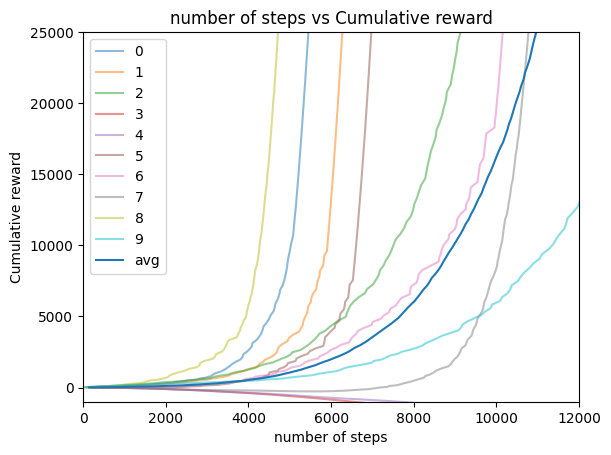

In [73]:
x_data_avg = np.zeros((EPISODES))
y_data_avg = np.zeros((EPISODES))
for i in range(data.keys().__len__()):
    x_data = np.cumsum([value[0] for value in list(data[i].values())])
    y_data = np.cumsum([value[1] for value in list(data[i].values())])
    
    x_data_avg = [sum(x) for x in zip(x_data, x_data_avg)]
    
    y_data_avg = [sum(y) for y in zip(y_data, y_data_avg)]
    
    plt.plot(x_data, y_data, label=i, alpha=0.5)

x_data_avg = [a/10 for a in x_data_avg]
y_data_avg = [a/10 for a in y_data_avg]

plt.plot(x_data_avg, y_data_avg, label="avg")

# Adding labels and title
plt.xlabel('number of steps')
plt.ylabel('Cumulative reward')
plt.title('number of steps vs Cumulative reward')
plt.ylim(-1000,25000)
plt.xlim(0,12000)

plt.legend()

# Display the plot
plt.show()